<a href="https://colab.research.google.com/github/danielnachshoni/hw4_facerecognition/blob/main/HW_4__Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hw 4 this task  focused on face recognition, using MTCNN model which knows as a simple and quick model.

Quick start in install 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# !pip install /content/facenet_pytorch-2.2.7-py3-none-any.whl
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from facenet_pytorch import InceptionResnetV1

# For a model pretrained on VGGFace2
model = InceptionResnetV1(pretrained='vggface2').eval()

# For a model pretrained on CASIA-Webface
model = InceptionResnetV1(pretrained='casia-webface').eval()

# For an untrained model with 100 classes
model = InceptionResnetV1(num_classes=100).eval()

# For an untrained 1001-class classifier
model = InceptionResnetV1(classify=True, num_classes=1001).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

  0%|          | 0.00/111M [00:00<?, ?B/s]

In [ ]:
# git submodule add https://github.com/timesler/facenet-pytorch.git facenet_pytorch

SyntaxError: ignored

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(image_size=160, margin=0)

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()


In [ ]:
from PIL import Image

img = Image.open('/content/drive/MyDrive/DeepLFiles/HW_4/DataSet/data/test_images/angelina_jolie/1.jpg')

# Get cropped and prewhitened image tensor
img_cropped = mtcnn(img)

# Calculate embedding (unsqueeze to add batch dimension)
img_embedding = resnet(img_cropped.unsqueeze(0))

# Or, if using for VGGFace2 classification
resnet.classify = True
img_probs = resnet(img_cropped.unsqueeze(0))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


In [ ]:
img.show()

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

import facenet-pytorch

Define MTCNN module
 our modle base on coda divce


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.  See help(MTCNN) for more details.

In [ ]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

et a sample video
We begin by loading a video with some faces in it. The mmcv PyPI package by mmlabs is used to read the video frames (it can be installed with pip install mmcv). Frames are then converted to PIL images.

In [ ]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [ ]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('/content/drive/MyDrive/DeepLFiles/HW_4/DataSet/data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999880
Face detected with probability: 0.999992


In [ ]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

In [ ]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  kate_siegel  paul_rudd  \
angelina_jolie        0.000000        1.447480     0.887728   1.429847   
bradley_cooper        1.447480        0.000000     1.313749   1.013448   
kate_siegel           0.887728        1.313749     0.000000   1.388377   
paul_rudd             1.429847        1.013448     1.388377   0.000000   
shea_whigham          1.399073        1.038684     1.379655   1.100503   

                shea_whigham  
angelina_jolie      1.399073  
bradley_cooper      1.038684  
kate_siegel         1.379655  
paul_rudd           1.100503  
shea_whigham        0.000000  


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
     |████████████████████████████████| 46.3 MB 8.2 MB/s 
     |████████████████████████████████| 190 kB 5.3 MB/s 


In [ ]:
from facenet_pytorch import MTCNN

import torch
import numpy as np
import  cv2
import mmcv
from PIL import Image, ImageDraw
from IPython import display

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [ ]:
mtcnn = MTCNN(keep_all=True, device=device)

In [ ]:
from matplotlib import pyplot as plt

[<PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A490>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A510>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A590>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A610>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A690>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A710>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A790>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A810>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A890>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A390>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A950>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557A9D0>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557AA50>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557AAD0>,
 <PIL.Image.Image image mode=RGB size=640x360 at 0x7F8D9557AB50>,
 <PIL.Imag

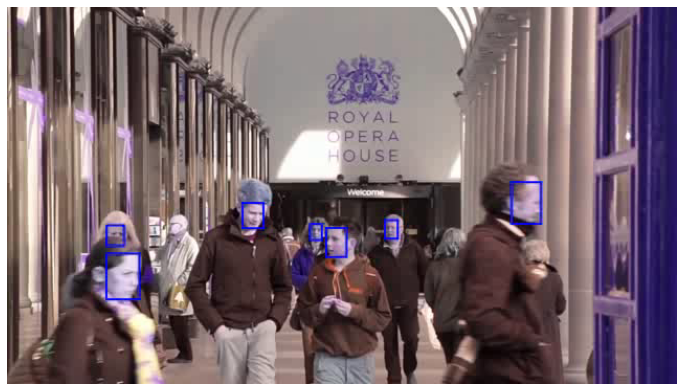

In [ ]:
# load the video-- 
v_cap = cv2.VideoCapture('/video_tracked[1].mp4')
success, frame = v_cap.read()
plt.figure(figsize=(12, 8))
plt.imshow(frame)
plt.axis('off')


video = mmcv.VideoReader('/video_tracked[1].mp4')



frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]
display.display(frames)

Tracking frame: 5

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Tracking frame: 105
Done


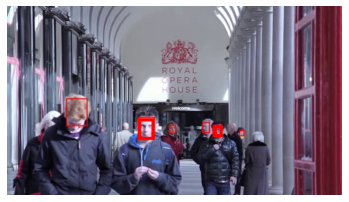

In [ ]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
    plt.imshow(frame_draw)
    plt.axis('off');


print('\nDone')

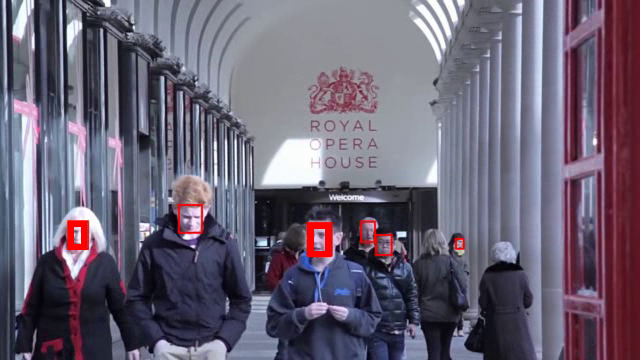

In [ ]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

In [ ]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()